<a href="https://colab.research.google.com/github/ariffinsarhid/Predicting-Airline-On-Time-Performance-In-Progress-/blob/main/Copy_of_1st_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore')
import io

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

In [2]:
url_1 = 'https://raw.githubusercontent.com/ariffinsarhid/Predicting-Airline-On-Time-Performance-In-Progress-/main/Data/final_table.csv'

df = pd.read_csv(url_1, index_col='flightdate')
df = df.drop(columns= 'Unnamed: 0')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86761 entries, 11/06/19 to 09/02/18
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             86761 non-null  int64  
 1   quarter                          86761 non-null  int64  
 2   month                            86761 non-null  int64  
 3   dayofmonth                       86761 non-null  int64  
 4   dayofweek                        86761 non-null  int64  
 5   flight_number_reporting_airline  86761 non-null  int64  
 6   originairportid                  86761 non-null  int64  
 7   destairportid                    86761 non-null  int64  
 8   destwac                          86761 non-null  int64  
 9   crsdeptime                       86761 non-null  int64  
 10  deptime                          86761 non-null  float64
 11  crsarrtime                       86761 non-null  int64  
 12  arrdel15     

In [4]:
df = pd.get_dummies(df, columns = ['airline', 'origincity', 'destcity'])

In [5]:
df.head()

,year,quarter,month,dayofmonth,dayofweek,flight_number_reporting_airline,originairportid,destairportid,destwac,crsdeptime,deptime,crsarrtime,arrdel15,crselapsedtime,airtime,flights,distance,distancegroup,airline_Alaska Airlines Inc.,airline_Allegiant Air,airline_American Airlines Inc.,airline_Delta Air Lines Inc.,airline_Endeavor Air Inc.,airline_Envoy Air,airline_ExpressJet Airlines LLC,airline_Frontier Airlines Inc.,airline_Hawaiian Airlines Inc.,airline_JetBlue Airways,airline_Mesa Airlines Inc.,airline_PSA Airlines Inc.,airline_Republic Airline,airline_SkyWest Airlines Inc.,airline_Southwest Airlines Co.,airline_Spirit Air Lines,airline_United Air Lines Inc.,airline_Virgin America,origincity_Aberdeen,origincity_Abilene,origincity_Adak Island,origincity_Aguadilla,...,destcity_Spokane,destcity_Springfield,destcity_St. Cloud,destcity_St. George,destcity_St. Louis,destcity_St. Petersburg,destcity_State College,destcity_Staunton,destcity_Stillwater,destcity_Stockton,destcity_Sun Valley/Hailey/Ketchum,destcity_Syracuse,destcity_Tallahassee,destcity_Tampa,destcity_Texarkana,destcity_Toledo,destcity_Traverse City,destcity_Trenton,destcity_Tucson,destcity_Tulsa,destcity_Twin Falls,destcity_Tyler,destcity_Valdosta,destcity_Valparaiso,destcity_Vernal,destcity_Waco,destcity_Washington,destcity_Waterloo,destcity_Watertown,destcity_West Palm Beach/Palm Beach,destcity_West Yellowstone,destcity_White Plains,destcity_Wichita,destcity_Wichita Falls,destcity_Williston,destcity_Wilmington,destcity_Worcester,destcity_Wrangell,destcity_Yakutat,destcity_Yuma
flightdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11/06/19,2019,2,6,11,2,3459,10397,10868,37,1950,2331.0,2057,1.0,67.0,35.0,1,192,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10/04/18,2018,2,4,10,2,5198,10397,12197,22,928,923.0,1150,0.0,142.0,99.0,1,780,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
01/10/19,2019,4,10,1,2,3358,12953,11057,36,1910,2004.0,2130,1.0,140.0,76.0,1,544,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27/07/18,2018,3,7,27,5,5388,10821,14492,36,1526,1558.0,1636,1.0,70.0,46.0,1,255,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
04/03/19,2019,1,3,4,1,5179,14122,12478,22,604,631.0,745,1.0,101.0,63.0,1,340,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86761 entries, 11/06/19 to 09/02/18
Columns: 721 entries, year to destcity_Yuma
dtypes: float64(4), int64(14), uint8(703)
memory usage: 70.7+ MB


## We will try to run our model using 10% of our dataset first. This is to get a first glimpse of how our model will work. 

In [7]:
df_sample = df.sample(frac=0.1, replace = False, random_state=42)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8676 entries, 20/12/19 to 05/05/18
Columns: 721 entries, year to destcity_Yuma
dtypes: float64(4), int64(14), uint8(703)
memory usage: 7.1+ MB


### Preprocessing

In [8]:
x = df_sample.drop(['arrdel15'],axis= 1)
y = df_sample.arrdel15

#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 42)


print(x_train.shape, y_train.shape)

(6507, 720) (6507,)


## Check the baseline score

In [9]:
y.value_counts()  

0.0    7050
1.0    1626
Name: arrdel15, dtype: int64

In [10]:
y.shape

(8676,)

In [11]:
def score(model,x_train, x_test):
    
    """
    This function scores the model by returning the confusion matrix and classification report of the model
    
    """
    
    # Get predictions
    preds = model.predict(x_test)
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Flight Not Delay','Flight Delay']).plot(cmap='GnBu')

    print("Training Score:",model.score(x_train,y_train))
    print("Testing Score:",model.score(x_test,y_test))
    print("\n")
    print(classification_report(y_test, preds)) 


In [12]:
def fimportance_df(list_of_features,list_of_feature_scores):
    
    """
    This function returns a dataframe, ranking the top features as the top rows.
    
    """
    abs_list = [abs(i) for i in list_of_feature_scores]
    fimportance = zip(list_of_features, list_of_feature_scores, abs_list)
    df_feature = pd.DataFrame(fimportance,columns=[['Feature','Feature_Significance','Feature_Significance_Abs']])
    df_feature = df.sort_values("Feature_Significance_Abs",ascending=False).reset_index(drop=True)
    return df_feature[['Feature','Feature_Significance']]

In [13]:
def fimportance(list_of_features, list_of_feature_scores):

    """
    This function plots the feature importance/coefficients as horizontal bar plot.
    
    It takes in dataframe generated from the fimportance_df function.
    
    """    
    
    # Initialize the matplotlib figure
    df=fimportance_df(list_of_features, list_of_feature_scores)
    
    with sns.axes_style("whitegrid"):
        f, ax = plt.subplots(figsize=(8, 12))
        
        # Plot the features
        sns.set_color_codes("muted")
        hbar = sns.barplot(x="Feature_Significance",
                            y="Feature",
                            data=df,
                            color="b")
        for bar in hbar.patches:
   
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        # x-coordinate: bar.get_width()
        # y-coordinate: bar.get_y()+bar.get_height()/2
        # free space to be left to make graph pleasing: (0, 0)
        # ha and va stand for the horizontal and vertical alignment
            hbar.annotate(format(bar.get_width(), '.3f'), # text is width of bar
                      (bar.get_width(), bar.get_y()+bar.get_height()/2), # coordinates of each annotation
                      ha='left', va='center',
                       size=10, xytext=(2, 0),
                       textcoords='offset points')
          # Add axis label
    ax.set(title= "Feature Significance",
           xlabel="Score",
          ylabel="Feature")
    ax.xaxis.get_label().set_fontsize(20)
    ax.yaxis.get_label().set_fontsize(20)
    ax.title.set_fontsize(30)
    sns.despine(left=True, bottom=True)


In [14]:
def roc(model, model_name, X_train, X_test): 
    
    """
    This function generates the ROC/AUC curve of the model.
    
    Due to the imbalanced nature of the data, the preferred metrics for this project is ROC/AUC.
    
    """      
    
    plt.figure(figsize=(16,10))
    
    # Predict probabilities from X_test
    df = pd.DataFrame(model.predict_proba(X_test))
    preds = df.drop(columns=0)
    
    # 
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)

    df2 = pd.DataFrame(model.predict_proba(X_train))
    preds2 = df2.drop(columns=0)
    fpr2, tpr2, _ = roc_curve(y_train, preds2)
    auc2 = roc_auc_score(y_train, preds2)
    
    with sns.axes_style(style="darkgrid"):
        plt.plot(fpr,tpr,color='orange',label="%s test, auc=%s" %(model_name, format(auc,".3f")))
        plt.plot(fpr2,tpr2,color='blue',label="%s train, auc=%s" %(model_name, format(auc2,".3f")))
        plt.plot(y_test,y_test,color='gray',linestyle=':') #baseline 50%
    plt.legend(loc='lower right')    
    
    sns.despine(left=True,bottom=True)

In [15]:
preprocess_pipe = make_pipeline(MinMaxScaler())

In [16]:
# preprocess data through pipeline for modelling

#x_train_t = preprocess_pipe.fit_transform(x_train)
#x_test_t = preprocess_pipe.transform(x_test)

In [17]:
#create pipeline
lr_pipe = make_pipeline(SMOTE(random_state = 42), 
                        LogisticRegression(max_iter=200, random_state = 42)
                       )
    

# define grid params for logistic regression
lr_params = {
    'logisticregression__C': [0.02, 0.05, 0.1],
    'logisticregression__solver' : ['newton-cg','saga', 'sag', 'lbfgs'],
    'logisticregression__multi_class': ['multinomial', 'ovr', 'auto'],
    'logisticregression__penalty':['l1','l2','elasticnet'],
    'logisticregression__l1_ratio':[None, 0.25,0.5,0.75],
    'logisticregression__class_weight':[None, 'balanced']
}
    

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_lr = GridSearchCV(lr_pipe, param_grid = lr_params, verbose = 1, n_jobs=-1, cv=3, scoring='roc_auc')

In [18]:
# preprocess data through pipeline for modelling

x_train_t = preprocess_pipe.fit_transform(x_train)
x_test_t = preprocess_pipe.transform(x_test)

In [19]:
grid_lr.fit(x_train_t,y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=200,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.02, 0.05, 0.1],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__l1_ratio': [None, 0.25, 0.5,
                                                          0.75],
                         'logisticregression__multi_class': ['multinomial',
                                                             'ovr', 'auto'],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'saga',
       

In [20]:
print("best score", grid_lr.best_score_)
print("best params", grid_lr.best_params_)

best score 0.6876541014907414
best params {'logisticregression__C': 0.1, 'logisticregression__class_weight': None, 'logisticregression__l1_ratio': None, 'logisticregression__multi_class': 'multinomial', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


Training Score: 0.7614417671554415
Testing Score: 0.7155640436001106


              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78      1763
         1.0       0.33      0.63      0.43       406

    accuracy                           0.69      2169
   macro avg       0.61      0.67      0.61      2169
weighted avg       0.79      0.69      0.72      2169



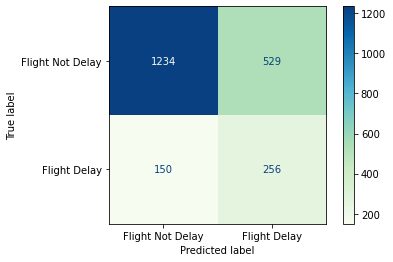

In [21]:
score(grid_lr, x_train_t, x_test_t)

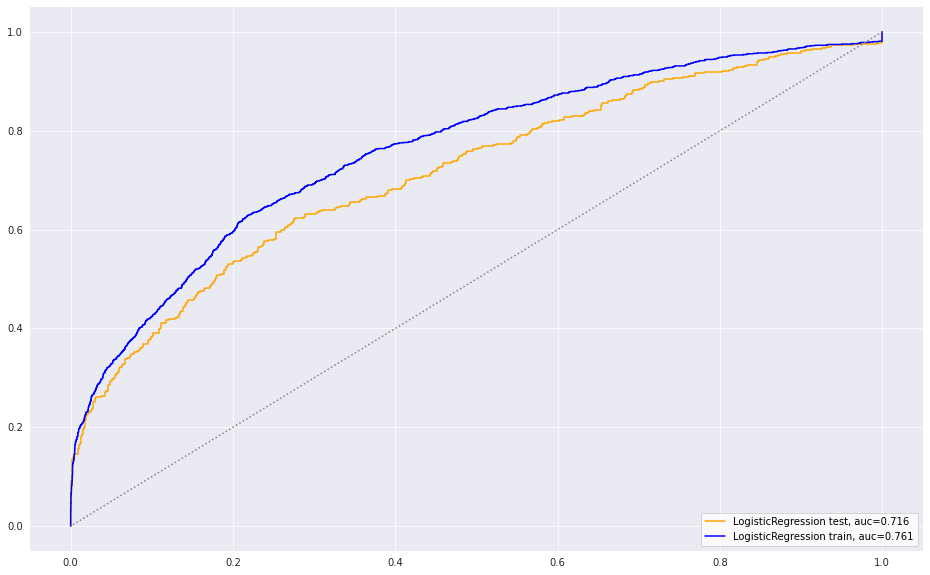

In [22]:
roc(grid_lr,"LogisticRegression", x_train_t, x_test_t)

In [23]:
lr_score = grid_lr.best_estimator_.named_steps.logisticregression.coef_
lr_score

array([[-1.99274048e-01, -6.26438102e-02, -1.41992042e-05,
        -4.11460482e-03, -5.46530417e-02,  0.00000000e+00,
        -9.98669332e-02, -3.15852780e-02,  0.00000000e+00,
        -3.43204252e+00,  4.40585602e+00,  6.48179741e-02,
         0.00000000e+00,  6.00890291e-01,  0.00000000e+00,
         0.00000000e+00, -3.80510220e-01, -2.03182106e-02,
         0.00000000e+00,  1.21758732e-02, -3.19204207e-02,
         1.37835234e-02,  1.35541028e-01,  0.00000000e+00,
         1.40084176e-01,  0.00000000e+00,  8.80085489e-02,
         0.00000000e+00,  0.00000000e+00, -1.77048377e-02,
         0.00000000e+00, -1.10791466e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [24]:
lr_score2 = [np.exp(i) for i in lr_score[0]]
lr_score2

[0.8193253281340385,
 0.9392779753046362,
 0.9999858008966015,
 0.9958938485644919,
 0.9468135957993224,
 1.0,
 0.9049578298956015,
 0.9689083264107626,
 1.0,
 0.03232085733995627,
 81.92924561874442,
 1.0669647915112432,
 1.0,
 1.8237417393271889,
 1.0,
 1.0,
 0.6835125786491629,
 0.9798868133004118,
 1.0,
 1.0122503009393087,
 0.9685836581927796,
 1.0138789540763355,
 1.1451561778039618,
 1.0,
 1.1503706282135036,
 1.0,
 1.0919974573508848,
 1.0,
 1.0,
 0.9824509720324731,
 1.0,
 0.8951253932271748,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9903701676040686,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9392022071496208,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.2464998708587027,
 1.0,
 1.0,
 1.0,
 1.0,
 1.307346901077274,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1

In [25]:
#df = pd.DataFrame({'name of issuer': name, 'cusip':cu})  
#feature = pd.DataFrame(list(zip(x_train_t.columns, lr_score)))
#feature

In [26]:
#x_train.columns

In [27]:
#lr_coefficient = sorted(zip(map(lambda x_train: round(x_train_t,4), lr_score),x_train.columns), reverse = True)

In [30]:
lr_score = grid_lr.best_estimator_.named_steps.logisticregression.coef_
lr_score2 = [np.exp(i) for i in lr_score[0]]
fimportance(x_train.columns.to_list(), lr_score2)

KeyError: ignored

In [31]:
##random forest

In [33]:
# create modelling pipeline with SMOTE to deal with imbalanced classes

rf_pipe = make_pipeline(SMOTE(random_state=42),
                           
                           ### Insert Model here for future modelling ###
                           
                           RandomForestClassifier(random_state=42),
                          )

# define grid params for random forest classifier
rf_params = {
    'randomforestclassifier__n_estimators':[20,50,100],
    'randomforestclassifier__max_depth':[5,20,50],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__max_leaf_nodes':[5,10,15],
    'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_rf = GridSearchCV(rf_pipe, param_grid = rf_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [35]:
grid_rf.fit(x_train_t,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [5, 20, 50],
                         'randomforestclassifier__max_leaf_nodes': [5, 10, 15],
                         'randomforestclassifier__n_estimators': [20, 50, 100]},
             scoring='roc_auc', verbose=1)

In [36]:
print("best score", grid_rf.best_score_)
print("best params", grid_rf.best_params_)

best score 0.6179405711501644
best params {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_leaf_nodes': 15, 'randomforestclassifier__n_estimators': 100}


Training Score: 0.6647199130561507
Testing Score: 0.6023236254816438


              precision    recall  f1-score   support

         0.0       0.84      0.66      0.74      1763
         1.0       0.24      0.46      0.31       406

    accuracy                           0.62      2169
   macro avg       0.54      0.56      0.52      2169
weighted avg       0.73      0.62      0.66      2169



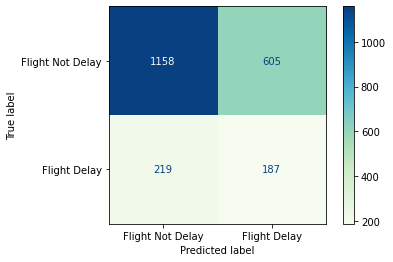

In [37]:
score(grid_rf, x_train_t, x_test_t)

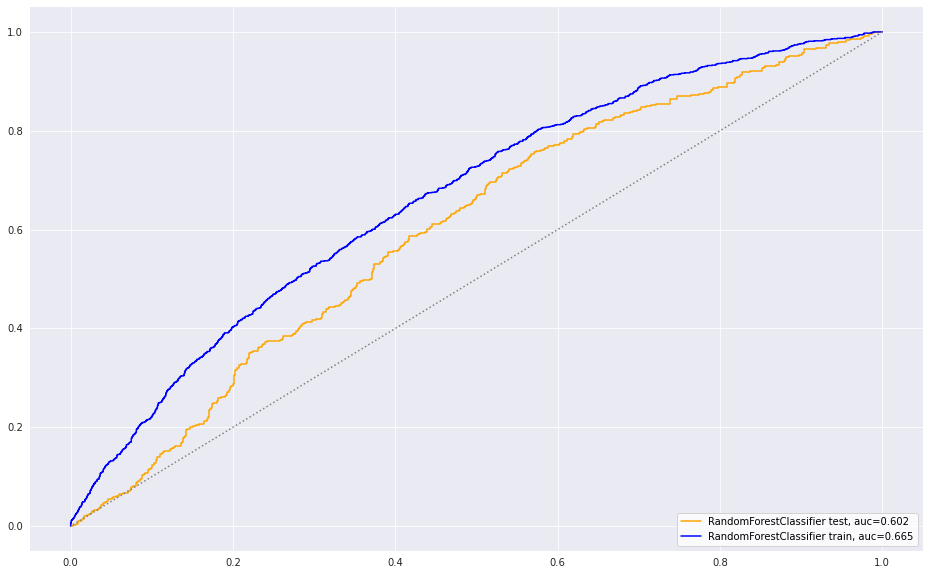

In [38]:
roc(grid_rf,"RandomForestClassifier", x_train_t, x_test_t)

In [39]:
rf_score = grid_rf.best_estimator_.named_steps.randomforestclassifier.feature_importances_
fimportance(x_train_t.columns.to_list(), rf_score)

AttributeError: ignored